In [123]:
!pip3 install torch torchvision
!pip install scikit-learn
!pip install -U torch datasets transformers
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━

In [124]:
import torch
import os
from torchvision.datasets import  MNIST, CIFAR10, CIFAR100, STL10
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
import umap.umap_ as umap

In [204]:
#Select the dataset you want to test

folder = "/home/jovyan/data/" #folder to store the data
#data = MNIST(root=f"{folder}MNIST", download=True, train=False)
#data = CIFAR10(root=f"{folder}CIFAR10", download=True, train=False)
#data = CIFAR100(root=f"{folder}CIFAR100", download=True, train=False)
data = STL10(root=f"{folder}STL10", download=True, split="train")

Files already downloaded and verified


In [205]:
data

Dataset STL10
    Number of datapoints: 5000
    Root location: /home/jovyan/data/STL10
    Split: train

In [206]:
data[0]

(<PIL.Image.Image image mode=RGB size=96x96>, 1)

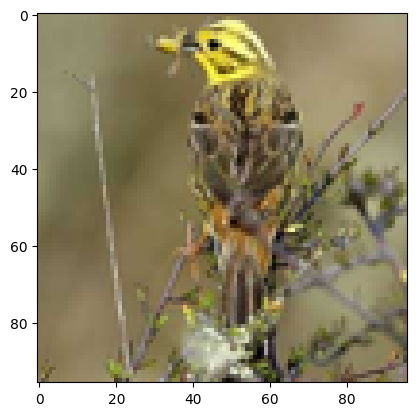

In [207]:
plt.imshow(data[0][0])

In [208]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

# if you have CUDA or MPS, set it to the active device like this
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id, cache_dir="/home/jovyan/models")
processor = CLIPProcessor.from_pretrained(model_id, cache_dir="/home/jovyan/models")
model = CLIPModel.from_pretrained(model_id, cache_dir="/home/jovyan/models").to(device)

In [209]:
#Write the list of prompts
prompts = ["a big plane", "a cat in the jungle", "a luxurious yellow car"]


# create transformer-readable tokens
inputs = []
for prompt in prompts:
    input = tokenizer(prompt, return_tensors="pt").to(device)
    inputs.append(input)

In [210]:
# use CLIP to encode tokens into a meaningful embedding
text_embeddings = []
for input in inputs:
    text_emb = model.get_text_features(**input)
    text_embeddings.append(text_emb)

In [211]:
np.random.seed(42)

sample_size = 2000 # the number of examples to be examined
sample_idx = np.random.randint(0, len(data), sample_size).tolist()
# extract the image sample from the dataset
images = [data[i] for i in sample_idx]

In [212]:
from tqdm.auto import tqdm

batch_size = 16
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    # select batch of images
    batch = [item[0] for item in images[i:i+batch_size]]
    #batch = images[i:i+batch_size][0]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    # convert to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    # add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape

100%|██████████| 125/125 [00:15<00:00,  7.93it/s]


(2000, 512)

In [213]:
image_arr.min(), image_arr.max()

(-9.184982, 3.4680586)

In [214]:
image_arr = image_arr / np.linalg.norm(image_arr, axis=0)
image_arr.min(), image_arr.max()

(-0.112048514, 0.10564702)

In [215]:
#Calculate the scores between the prompt and every image
indices = []
scores = []
top_k = 5 #Number of winner examples to retrieve
for text_emb in text_embeddings:
    text_emb = text_emb.cpu().detach().numpy()
    score = np.dot(text_emb, image_arr.T)
    # get the top k indices for most similar vecs
    idx = np.argsort(-score[0])[:top_k]
    indices.append(idx)
    scores.append(score)

--------a big plane---------
Index: 1536, Score: 1.1112979650497437


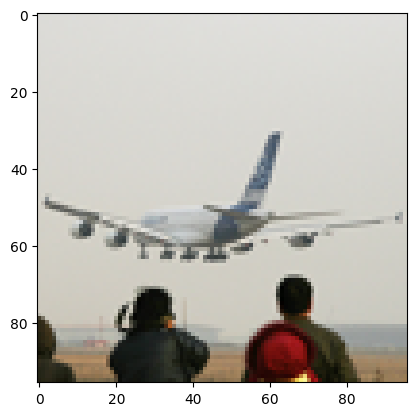

Index: 86, Score: 1.1036489009857178


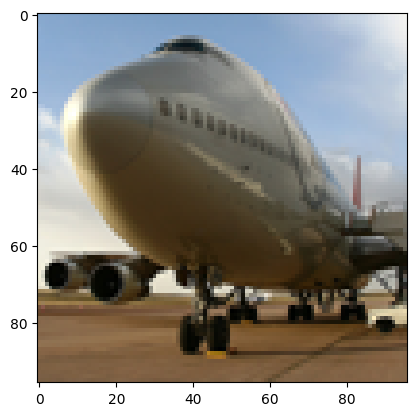

Index: 1481, Score: 1.1012310981750488


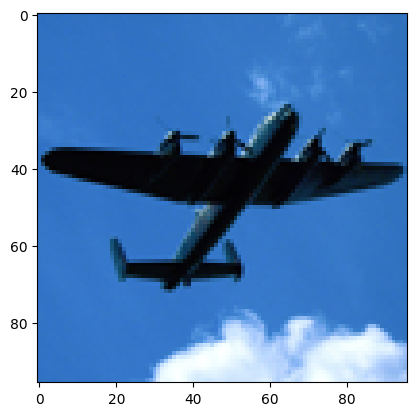

Index: 396, Score: 1.1012310981750488


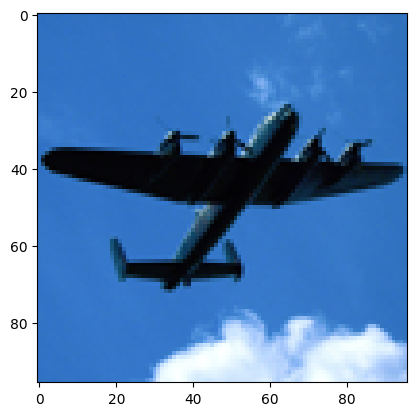

Index: 1855, Score: 1.1003271341323853


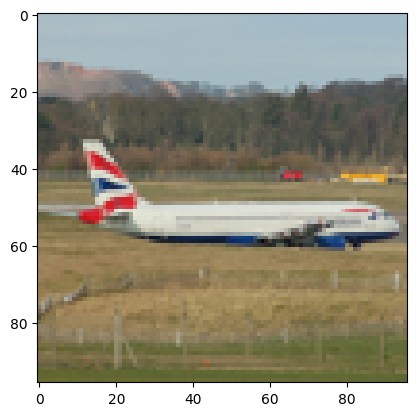

--------a cat in the jungle---------
Index: 219, Score: 1.0576287508010864


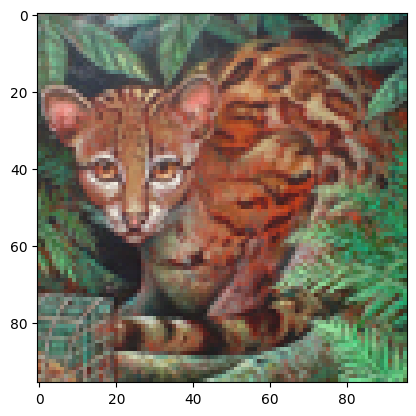

Index: 721, Score: 0.915319561958313


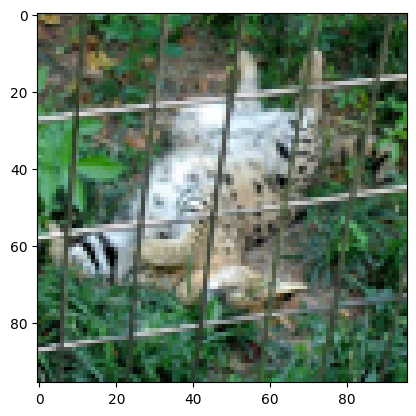

Index: 663, Score: 0.8980756402015686


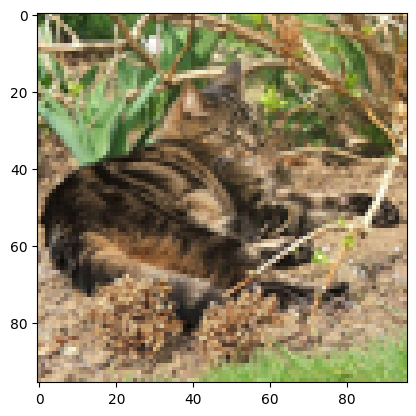

Index: 117, Score: 0.8879702091217041


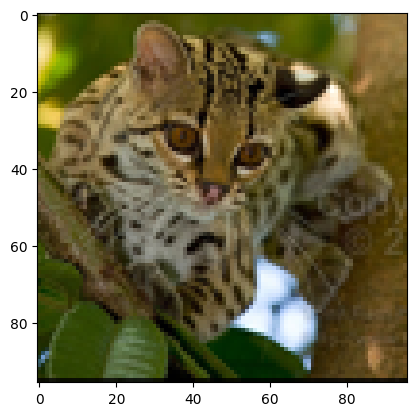

Index: 408, Score: 0.8879702091217041


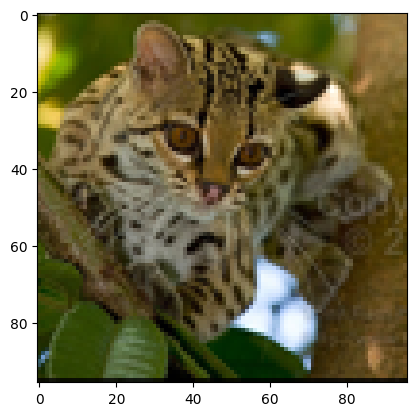

--------a luxurious yellow car---------
Index: 245, Score: 0.9872364401817322


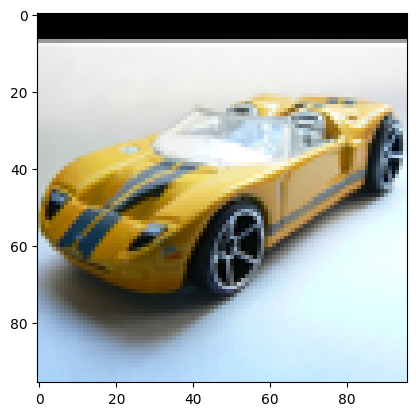

Index: 1860, Score: 0.9803917407989502


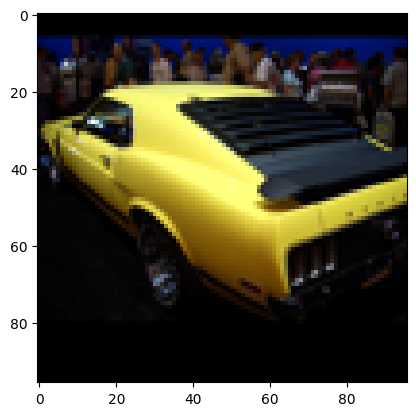

Index: 1822, Score: 0.9298266172409058


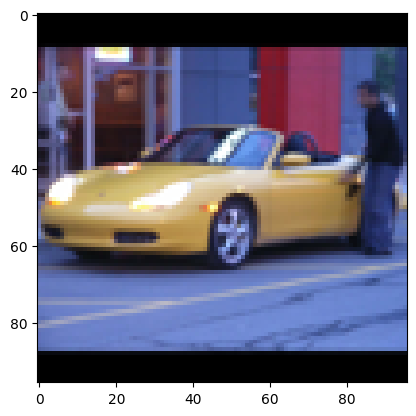

Index: 318, Score: 0.9220574498176575


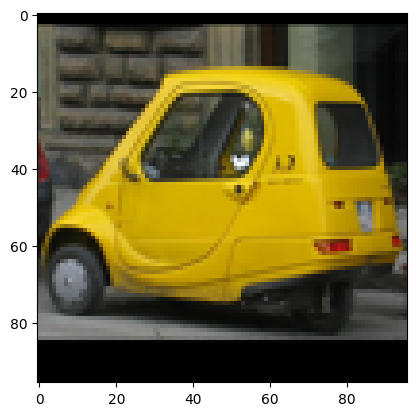

Index: 979, Score: 0.9188762307167053


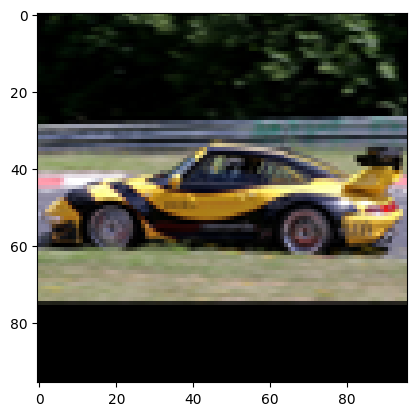

In [216]:
#Retrieve top-k highest scorers
for i,idx_array in enumerate(indices):
    print(f"--------{prompts[i]}---------")
    for idx in idx_array:
        print(f"Index: {idx}, Score: {scores[i][0][idx]}")
        plt.imshow(images[idx][0], cmap='gray')
        plt.show()

In [217]:
text_embeddings_cpu = [text_emb.cpu().detach().numpy() for text_emb in text_embeddings]

In [218]:
import umap.umap_ as umap

#UMAP reduction on the embedding space
arr = np.concatenate((image_arr, *text_embeddings_cpu), axis=0)
n_components = 3  # Number of dimensions for visualization
umap = umap.UMAP(
        n_components=n_components,
    )
embeddings_3d = umap.fit_transform(arr)

Plot embedding space

/tmp/ipykernel_734892/1336132468.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  prompt_color = plt.cm.get_cmap('tab20')(i)  # Get a color from the 'tab20' colormap
/tmp/ipykernel_734892/1336132468.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(embeddings_3d[-1-i, 0], embeddings_3d[-1-i, 1], embeddings_3d[-1-i, 2], c=prompt_point_color, alpha=1, marker="s", s=100, edgecolors="black")


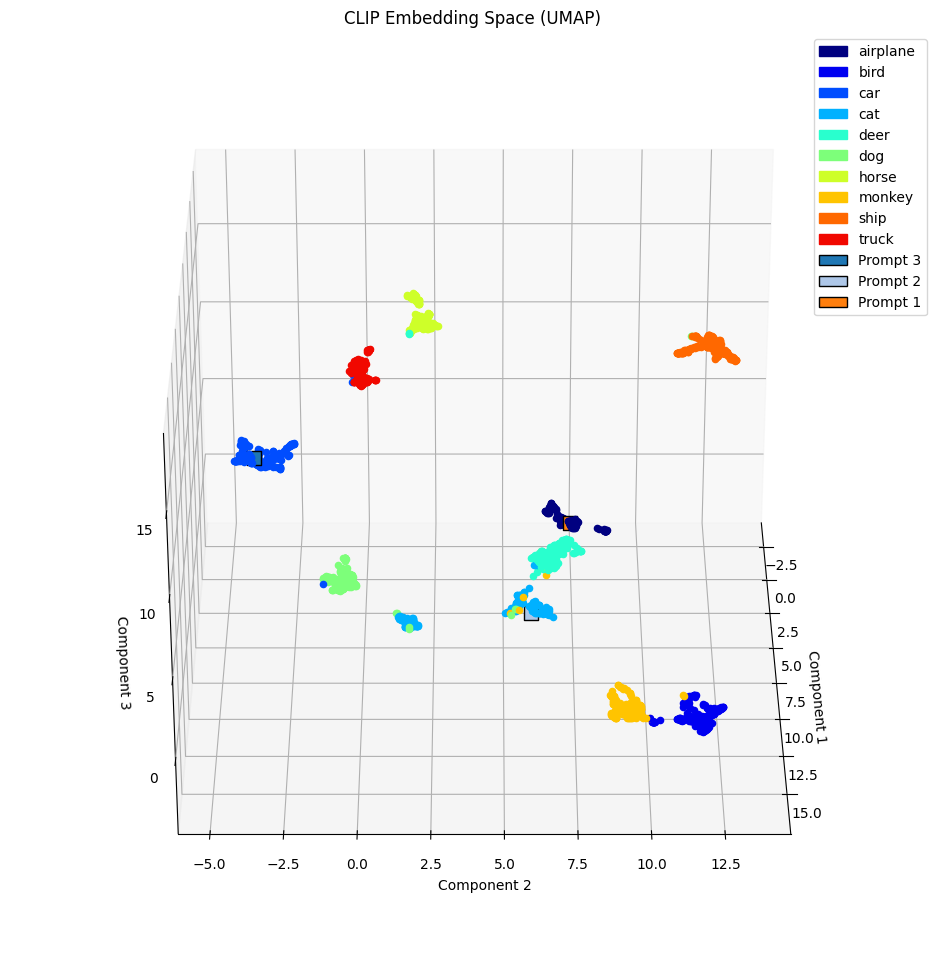

In [219]:
frames = 50 #Number of images in the animation. The returning time increases while increasing this value so be careful!

# Plot the 3D embeddings
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')

class_colors = [plt.cm.jet(class_id / len(data.classes)) for class_id in range(len(data.classes))]

legend_handles = []

for class_id, name_class in enumerate(data.classes):
    indices = [index for index, item in enumerate(images) if item[1] == class_id]
    class_color = class_colors[class_id]  # Get the class color
    
    # Plot a circular point of the class color in the legend
    legend_handles.append(mpatches.Patch(color=class_color, label=name_class))
    
    for i in indices:
        ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], c=[class_color])

# Create a legend with circular points for each prompt
for i, prompt in enumerate(prompts):
    prompt_color = plt.cm.get_cmap('tab20')(i)  # Get a color from the 'tab20' colormap
    prompt_label = f"Prompt {len(prompts)-i}"

    # Add the prompt label to the legend with a circular point
    legend_handles.append(mpatches.Patch(facecolor=prompt_color, label=prompt_label, edgecolor = "black"))

    # Plot the prompt point with the same color
    prompt_point_color = prompt_color if isinstance(prompt_color, tuple) else [prompt_color]
    ax.scatter(embeddings_3d[-1-i, 0], embeddings_3d[-1-i, 1], embeddings_3d[-1-i, 2], c=prompt_point_color, alpha=1, marker="s", s=100, edgecolors="black")

# Add the legend with custom handles
ax.legend(handles=legend_handles)

ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

plt.title("CLIP Embedding Space (UMAP)")

def update(frame):
        ax.view_init(elev=30., azim=3.6*frame)

ani = FuncAnimation(fig, update, frames=frames, interval=120)
ani.save('images/clip_latent_rotation.gif', writer='pillow')